In [1]:
import tensorflow as tf
import os
import json
import functools
import pyvista as pv
import numpy as np
from utils import *

2024-10-08 23:19:37.540682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-08 23:19:37.540722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:110: UserWarning: An

In [2]:
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()

In [3]:
def _parse(proto, meta):
  """Parses a trajectory from tf.Example."""
  feature_lists = {k: tf.io.VarLenFeature(tf.string)
                   for k in meta['field_names']}
  features = tf.io.parse_single_example(proto, feature_lists)
  out = {}
  for key, field in meta['features'].items():
    data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
    data = tf.reshape(data, field['shape'])
    if field['type'] == 'static':
      data = tf.tile(data, [meta['trajectory_length'], 1, 1])
    elif field['type'] == 'dynamic_varlen':
      length = tf.io.decode_raw(features['length_'+key].values, tf.int32)
      length = tf.reshape(length, [-1])
      data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
    elif field['type'] != 'dynamic':
      raise ValueError('invalid data format')
    out[key] = data
  return out

def load_dataset(path, split):
  """Load dataset."""
  with open(os.path.join(path, 'meta.json'), 'r') as fp:
    meta = json.loads(fp.read())
  ds = tf.data.TFRecordDataset(os.path.join(path, split+'.tfrecord'))
  ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
  ds = ds.prefetch(1)
  return ds

In [4]:
ds = load_dataset("../DATA/cylinder_flow", 'train')

2024-10-08 23:19:41.168143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-08 23:19:41.168656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-10-08 23:19:41.168732: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-08 23:19:41.169100: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

In [5]:
from torch_geometric.data import Data
import torch
from utils import  DelaunayTransform
from torch_geometric.loader import DataLoader


In [6]:
transform = DelaunayTransform()
dataset = []
for i, obs in enumerate(ds):
    new_obs = {}
    for key, value in obs.items():
        if 'mesh' in key or 'cells' in key or 'node_type' in key:
            key = key.replace('mesh_', '')
            new_obs[key] = torch.Tensor(value[0].numpy())
        else:
            new_obs["x_" + key] = torch.Tensor(value[0].numpy())
            new_obs["y_" + key] = torch.Tensor(value[-1].numpy())
    surf = torch.Tensor((obs['velocity'][0][:] == 0.0).numpy())
    surf = torch.logical_and(surf[:, 0], surf[:, 1])
    x = torch.cat([new_obs['x_velocity'], new_obs['x_pressure']], dim=1)
    y = torch.cat([new_obs['y_velocity'], new_obs['y_pressure']], dim=1)
    data = transform(Data(pos=new_obs["pos"], surf=surf, x=x, y=y))
    dataset.append(data)
data_loader = DataLoader(dataset=dataset, batch_size=1)
del dataset

In [13]:
import importlib
import utils
importlib.reload(utils)
from utils import *

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


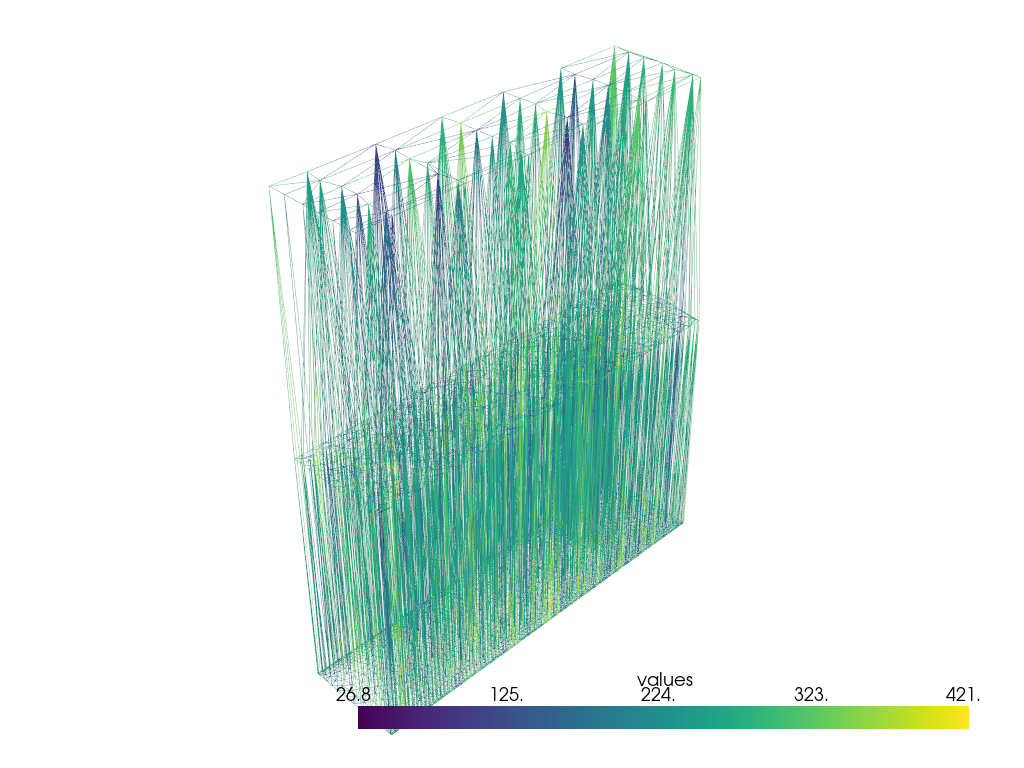

In [14]:
plot_graph(generate_coarse_graphs(next(iter(data_loader)), R=3, K=6, visualize=True))